In [3]:
# PART 1 Cleaning & Opportunity Identification
# 1.1 Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

In [4]:
# 1.2: Load the Dataset
data = pd.read_csv("/Users/john/Desktop/Dyson/Cro_Case_Dataset.csv", encoding='ISO-8859-1')

# Display the first few rows to verify the data is loaded correctly
data.head()


,Date,Traffic Source,Device Type,User Type,Session ID,Session Duration (seconds),Pages per Session,Added to Cart,Cart Abandonment,Checkout Stage 1 - Details,Checkout Stage 2 - Delivery,Checkout Stage 3 - Payment,Converted,Order Value,Product Category,Landing Page
0,4/7/2024,Social,Mobile,New,1001,310,5.7,True,True,True,True,True,True,£-,NaN,Deals
1,27/07/2024,Social,Mobile,Returning,1002,329,7.3,True,True,True,False,False,False,£-,NaN,Support
2,11/8/2024,Direct,Desktop,Returning,1003,378,4.4,True,True,True,True,True,True,£-,NaN,Deals
3,25/08/2024,Email,Tablet,New,1004,179,4.5,True,False,True,True,False,False,£-,NaN,Category Page
4,18/07/2024,Email,Desktop,New,1006,271,5.3,True,False,True,True,False,False,£-,NaN,Homepage


In [5]:
# 1.3 Data Cleaning and Preprocessing

# Strip leading and trailing whitespace from column names
data.columns = data.columns.str.strip()

# Verify that the column names are now clean
print("Column Names After Stripping Whitespace:")
print(data.columns.tolist())

# List of boolean columns to verify data types
bool_columns = ['Added to Cart', 'Cart Abandonment', 'Checkout Stage 1 - Details',
                'Checkout Stage 2 - Delivery', 'Checkout Stage 3 - Payment', 'Converted']

# Verify data types of boolean columns
print("\nData types of boolean columns before cleaning:")
print(data[bool_columns].dtypes)

# Check if boolean columns are of type 'object' and convert them if necessary
for col in bool_columns:
    if data[col].dtype == 'object':
        # Map string representations to actual booleans
        data[col] = data[col].map({'True': True, 'False': False, 'TRUE': True, 'FALSE': False})
        # Fill any missing values with False
        data[col] = data[col].fillna(False)
    else:
        # Ensure the column is of type 'bool'
        data[col] = data[col].astype('bool')

# Clean 'Order Value' column by removing currency symbols and converting to float
def clean_order_value(value):
    if isinstance(value, str):
        value = value.replace('£', '').replace(',', '').strip()
        if value in ['-', '']:
            return np.nan  # Treat '-' or empty strings as missing
        else:
            try:
                return float(value)
            except ValueError:
                return np.nan
    else:
        return value

data['Order Value'] = data['Order Value'].apply(clean_order_value)

# Fill missing 'Order Value' with 0 (if appropriate for your analysis)
data['Order Value'] = data['Order Value'].fillna(0)

# Verify data types after cleaning
print("\nData Types After Cleaning:")
print(data.dtypes)


Column Names After Stripping Whitespace:
['Date', 'Traffic Source', 'Device Type', 'User Type', 'Session ID', 'Session Duration (seconds)', 'Pages per Session', 'Added to Cart', 'Cart Abandonment', 'Checkout Stage 1 - Details', 'Checkout Stage 2 - Delivery', 'Checkout Stage 3 - Payment', 'Converted', 'Order Value', 'Product Category', 'Landing Page']

Data types of boolean columns before cleaning:
Added to Cart                  bool
Cart Abandonment               bool
Checkout Stage 1 - Details     bool
Checkout Stage 2 - Delivery    bool
Checkout Stage 3 - Payment     bool
Converted                      bool
dtype: object

Data Types After Cleaning:
Date                            object
Traffic Source                  object
Device Type                     object
User Type                       object
Session ID                       int64
Session Duration (seconds)       int64
Pages per Session              float64
Added to Cart                     bool
Cart Abandonment             

In [6]:
#date range
min_date = data['Date'].min()
max_date = data['Date'].max()

print("Min Date:", min_date)
print("Max Date:", max_date)


Min Date: 1/7/2024
Max Date: 9/8/2024


In [7]:
# 1.4 Conversion Rates, Drop-offs, and Revenue Loss

# Calculate Average Order Value (AOV) from converted sessions
converted_orders = data[data['Converted'] == True]
if not converted_orders.empty:
    AOV = converted_orders['Order Value'].mean()
else:
    AOV = 0  # If there are no converted orders, set AOV to 0

# Total number of unique sessions
total_sessions = data['Session ID'].nunique()

# Number of sessions at each stage
add_to_cart_sessions = data[data['Added to Cart'] == True]['Session ID'].nunique()
initiated_checkout_sessions = data[data['Checkout Stage 1 - Details'] == True]['Session ID'].nunique()
checkout_to_order_sessions = data[data['Checkout Stage 3 - Payment'] == True]['Session ID'].nunique()
converted_sessions = data[data['Converted'] == True]['Session ID'].nunique()

# Calculate rates at each stage
add_to_cart_rate = (add_to_cart_sessions / total_sessions) * 100 if total_sessions else 0
initiated_checkout_rate = (initiated_checkout_sessions / add_to_cart_sessions) * 100 if add_to_cart_sessions else 0
checkout_to_order_rate = (checkout_to_order_sessions / initiated_checkout_sessions) * 100 if initiated_checkout_sessions else 0
conversion_rate = (converted_sessions / total_sessions) * 100 if total_sessions else 0  # Overall conversion rate

# Calculate drop-off numbers at each stage
drop_off_add_to_cart = total_sessions - add_to_cart_sessions
drop_off_initiated_checkout = add_to_cart_sessions - initiated_checkout_sessions
drop_off_checkout_to_order = initiated_checkout_sessions - checkout_to_order_sessions
drop_off_conversion = checkout_to_order_sessions - converted_sessions

# Calculate drop-off rates at each stage
drop_off_rate_add_to_cart = (drop_off_add_to_cart / total_sessions) * 100 if total_sessions else 0
drop_off_rate_initiated_checkout = (drop_off_initiated_checkout / add_to_cart_sessions) * 100 if add_to_cart_sessions else 0
drop_off_rate_checkout_to_order = (drop_off_checkout_to_order / initiated_checkout_sessions) * 100 if initiated_checkout_sessions else 0
drop_off_rate_conversion = (drop_off_conversion / checkout_to_order_sessions) * 100 if checkout_to_order_sessions else 0

# Calculate potential revenue loss at each stage
# For users who dropped off at 'Add to Cart' stage
cumulative_conversion_rate_from_add_to_cart = (
    (initiated_checkout_rate / 100) *
    (checkout_to_order_rate / 100) *
    (conversion_rate / 100)
)
potential_conversions_add_to_cart = drop_off_add_to_cart * cumulative_conversion_rate_from_add_to_cart
potential_loss_add_to_cart = potential_conversions_add_to_cart * AOV

# For users who dropped off at 'Initiated Checkout' stage
cumulative_conversion_rate_from_initiated_checkout = (
    (checkout_to_order_rate / 100) *
    (conversion_rate / 100)
)
potential_conversions_initiated_checkout = drop_off_initiated_checkout * cumulative_conversion_rate_from_initiated_checkout
potential_loss_initiated_checkout = potential_conversions_initiated_checkout * AOV

# For users who dropped off at 'Checkout to Order' stage
cumulative_conversion_rate_from_checkout_to_order = (conversion_rate / 100)
potential_conversions_checkout_to_order = drop_off_checkout_to_order * cumulative_conversion_rate_from_checkout_to_order
potential_loss_checkout_to_order = potential_conversions_checkout_to_order * AOV

# For users who dropped off at 'Conversion' stage
potential_conversions_conversion = drop_off_conversion  # They are at the last step before conversion
potential_loss_conversion = potential_conversions_conversion * AOV

# Create a DataFrame to display the results as a table
import pandas as pd

# Define the stages and corresponding metrics
stages = ['Add to Cart', 'Initiated Checkout', 'Checkout to Order', 'Conversion']
rates = [add_to_cart_rate, initiated_checkout_rate, checkout_to_order_rate, conversion_rate]
drop_off_rates = [drop_off_rate_add_to_cart, drop_off_rate_initiated_checkout, drop_off_rate_checkout_to_order, drop_off_rate_conversion]
revenue_losses = [potential_loss_add_to_cart, potential_loss_initiated_checkout, potential_loss_checkout_to_order, potential_loss_conversion]

# Create the DataFrame
results_df = pd.DataFrame({
    'Stage': stages,
    'Rate (%)': rates,
    'Drop-off Rate (%)': drop_off_rates,
    'Potential Revenue Loss (£)': revenue_losses
})

# Format the numerical values
results_df['Rate (%)'] = results_df['Rate (%)'].map('{:.2f}%'.format)
results_df['Drop-off Rate (%)'] = results_df['Drop-off Rate (%)'].map('{:.2f}%'.format)
results_df['Potential Revenue Loss (£)'] = results_df['Potential Revenue Loss (£)'].map('£{:,.2f}'.format)

# Display the table
print(results_df)


                Stage Rate (%) Drop-off Rate (%) Potential Revenue Loss (£)
0         Add to Cart   63.51%            36.49%                  £1,695.27
1  Initiated Checkout   91.14%             8.86%                    £286.74
2   Checkout to Order   47.57%            52.43%                  £3,251.78
3          Conversion   26.13%             5.11%                    £576.73


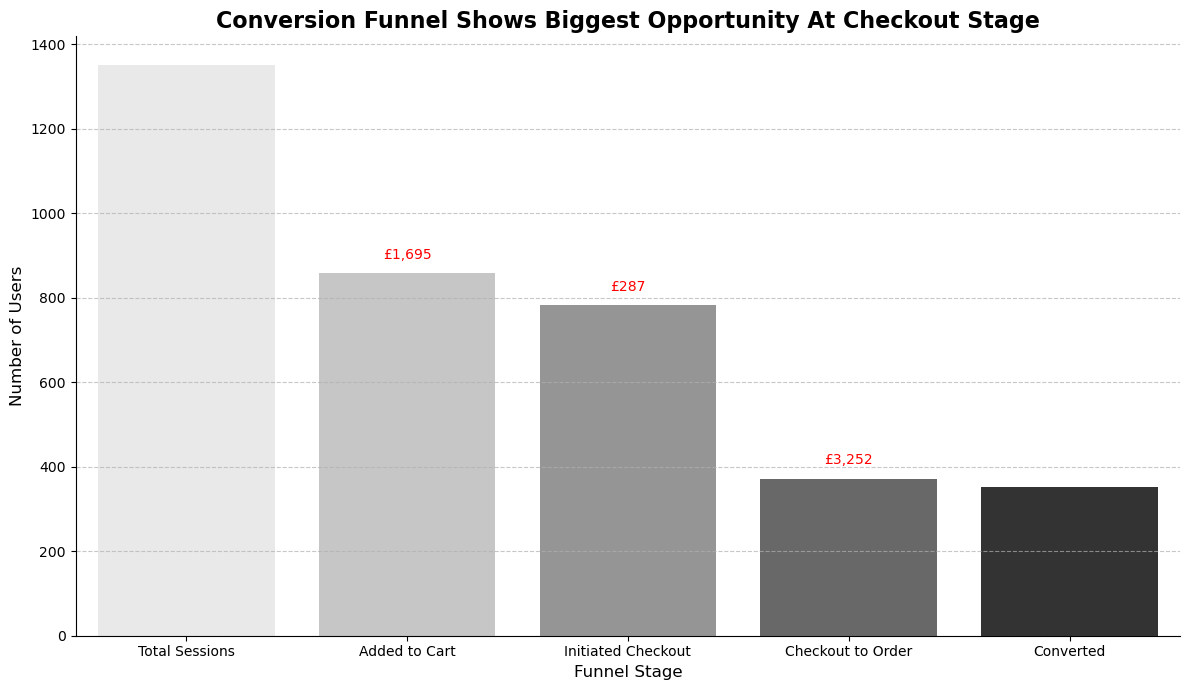

In [8]:
# 1.5 Funnel Visualization With Revenue Loss

# Create a DataFrame for the funnel stages with conversion rates and potential revenue loss
funnel_data = pd.DataFrame({
    'Stage': ['Total Sessions', 'Added to Cart', 'Initiated Checkout', 'Checkout to Order', 'Converted'],
    'Users': [
        total_sessions,
        add_to_cart_sessions,
        initiated_checkout_sessions,
        checkout_to_order_sessions,
        converted_sessions
    ],
    'Conversion Rate (%)': [
        100,
        (add_to_cart_sessions / total_sessions) * 100 if total_sessions else 0,
        (initiated_checkout_sessions / total_sessions) * 100 if total_sessions else 0,
        (checkout_to_order_sessions / total_sessions) * 100 if total_sessions else 0,
        (converted_sessions / total_sessions) * 100 if total_sessions else 0
    ],
    'Potential Revenue Loss (£)': [
        0,  # No revenue loss at the start
        potential_loss_add_to_cart,
        potential_loss_initiated_checkout,
        potential_loss_checkout_to_order,
        0   # No revenue loss for converted sessions
    ]
})

# Plot the funnel using a bar chart
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Stage', y='Users', data=funnel_data, palette='Greys')

# Annotate each bar with the revenue loss value
for index, row in funnel_data.iterrows():
    x = index
    y = row['Users']
    revenue_loss = row['Potential Revenue Loss (£)']
    # Format the revenue loss value
    if revenue_loss > 0:
        label = f"£{revenue_loss:,.0f}"
        # Place the text on top of the bar
        ax.text(x, y + (max(funnel_data['Users']) * 0.02), label, ha='center', va='bottom', fontsize=10, color='red')
    else:
        # No label for stages with zero revenue loss
        label = ""

# Customize the plot to fit Dyson branding
plt.title('Conversion Funnel Shows Biggest Opportunity At Checkout Stage', fontsize=16, fontweight='bold', color='#000000')
plt.ylabel('Number of Users', fontsize=12, color='#000000')
plt.xlabel('Funnel Stage', fontsize=12, color='#000000')
plt.xticks(fontsize=10, color='#000000')
plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#FFFFFF')
plt.gcf().set_facecolor('#FFFFFF')
sns.despine()

#save for prez
plt.tight_layout()
plt.savefig('Conversion Funnel Shows Biggest Opportunity At Checkout Stage.png', format='png', dpi=300)

plt.tight_layout()
plt.show()


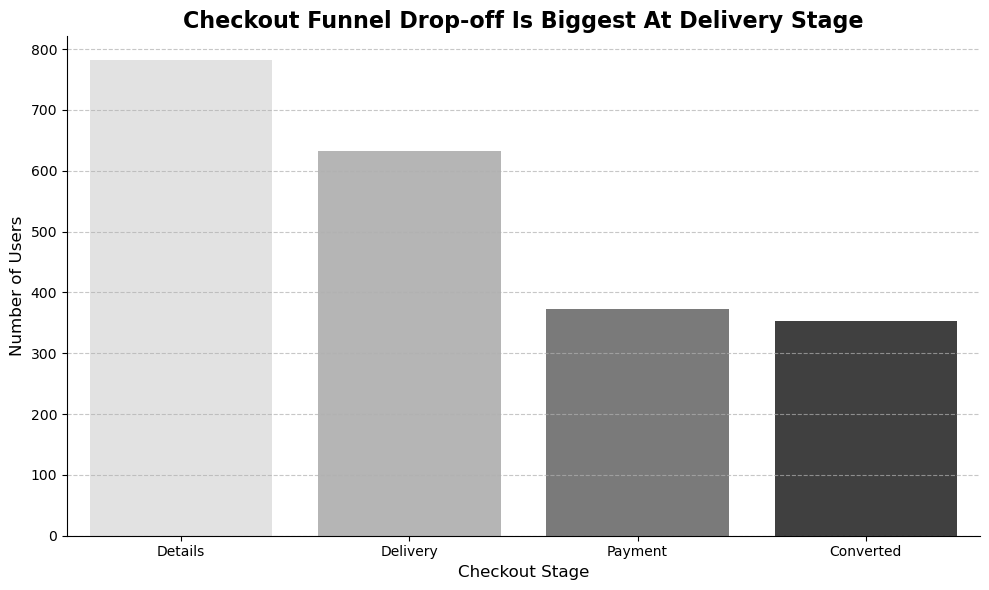

In [9]:
# PART 2 Opportunity Deep Dive
# 2.1 Checkout Stage Drop-off Analysis

# Number of sessions that reached each checkout stage
stage1_sessions = data[data['Checkout Stage 1 - Details'] == True]['Session ID'].nunique()
stage2_sessions = data[data['Checkout Stage 2 - Delivery'] == True]['Session ID'].nunique()
stage3_sessions = data[data['Checkout Stage 3 - Payment'] == True]['Session ID'].nunique()

# Create a DataFrame for the checkout stages with simplified stage names
checkout_stages = pd.DataFrame({
    'Stage': ['Details', 'Delivery', 'Payment', 'Converted'],
    'Users': [stage1_sessions, stage2_sessions, stage3_sessions, converted_sessions]
})

# Calculate drop-off percentages between stages
checkout_stages['Drop-off (%)'] = checkout_stages['Users'].pct_change(-1) * 100
checkout_stages['Drop-off (%)'] = checkout_stages['Drop-off (%)'].fillna(0).abs()

# Visualize the checkout funnel drop-off
plt.figure(figsize=(10,6))
sns.barplot(x='Stage', y='Users', data=checkout_stages, palette='Greys')

# Customize the plot to match Dyson branding
plt.title('Checkout Funnel Drop-off Is Biggest At Delivery Stage', fontsize=16, fontweight='bold', color='#000000')
plt.ylabel('Number of Users', fontsize=12, color='#000000')
plt.xlabel('Checkout Stage', fontsize=12, color='#000000')
plt.xticks(fontsize=10, color='#000000')
plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.savefig('Biggest Drop-Off At Delivery Stage.png', format='png', dpi=300)


plt.show()

In [10]:
# Print stages and their drop-off percentages
print(checkout_stages[['Stage', 'Drop-off (%)']])

       Stage  Drop-off (%)
0    Details     23.734177
1   Delivery     69.892473
2    Payment      5.382436
3  Converted      0.000000


  Traffic Source  Drop-off Rate at Delivery (%)
1          Email                      49.275362
2        Organic                      44.520548
4         Social                      40.800000
3    Paid Search                      37.391304
0         Direct                      34.259259


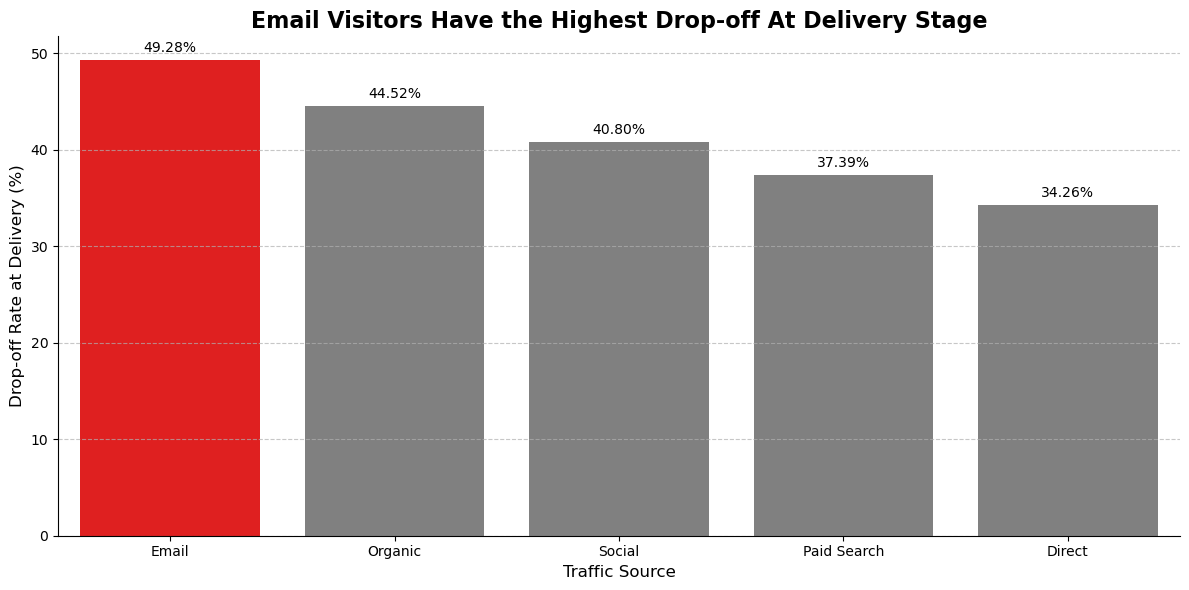

In [37]:
# 2.2 Traffic Source Segmentation
# Hypothesis: Customers from different traffic sources have different expectations

import matplotlib.pyplot as plt
import seaborn as sns

# Filter sessions that reached 'Delivery' stage
delivery_stage_sessions = data[data['Checkout Stage 2 - Delivery'] == True]

# Group by traffic source
grouped_data = delivery_stage_sessions.groupby('Traffic Source')

# Calculate the number of users who dropped off and who proceeded
drop_offs = grouped_data.apply(lambda x: x[x['Checkout Stage 3 - Payment'] == False]['Session ID'].nunique())
proceeds = grouped_data.apply(lambda x: x[x['Checkout Stage 3 - Payment'] == True]['Session ID'].nunique())

# Calculate drop-off rates
drop_off_rates = (drop_offs / (drop_offs + proceeds)) * 100
drop_off_rates = drop_off_rates.reset_index()
drop_off_rates.columns = ['Traffic Source', 'Drop-off Rate at Delivery (%)']

# Identify the traffic source with the highest drop-off rate
worst_traffic_source = drop_off_rates.loc[drop_off_rates['Drop-off Rate at Delivery (%)'].idxmax(), 'Traffic Source']

# Sort the data for better visualization
drop_off_rates = drop_off_rates.sort_values(by='Drop-off Rate at Delivery (%)', ascending=False)

print(drop_off_rates)

# Plotting
plt.figure(figsize=(12, 6))

# Define colors, highlighting the worst traffic source
colors = ['red' if x == worst_traffic_source else 'grey' for x in drop_off_rates['Traffic Source']]

# Create bar plot
ax = sns.barplot(x='Traffic Source', y='Drop-off Rate at Delivery (%)', data=drop_off_rates, palette=colors)

# Annotate the bars with the drop-off rates
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 0.5, f"{y:.2f}%", ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot to fit Dyson branding
plt.title('Email Visitors Have the Highest Drop-off At Delivery Stage', fontsize=16, fontweight='bold', color='#000000')
plt.xlabel('Traffic Source', fontsize=12, color='#000000')
plt.ylabel('Drop-off Rate at Delivery (%)', fontsize=12, color='#000000')
plt.xticks(fontsize=10, color='#000000')  # Labels are not rotated
plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#FFFFFF')
plt.gcf().set_facecolor('#FFFFFF')
sns.despine()

# Save the figure as PNG before showing it
plt.tight_layout()
plt.savefig('drop_off_rates_by_traffic_source.png', dpi=300)

plt.show()


  Device Type  Drop-off Rate at Delivery (%)
1      Mobile                      45.641026
2      Tablet                      40.186916
0     Desktop                      39.910314


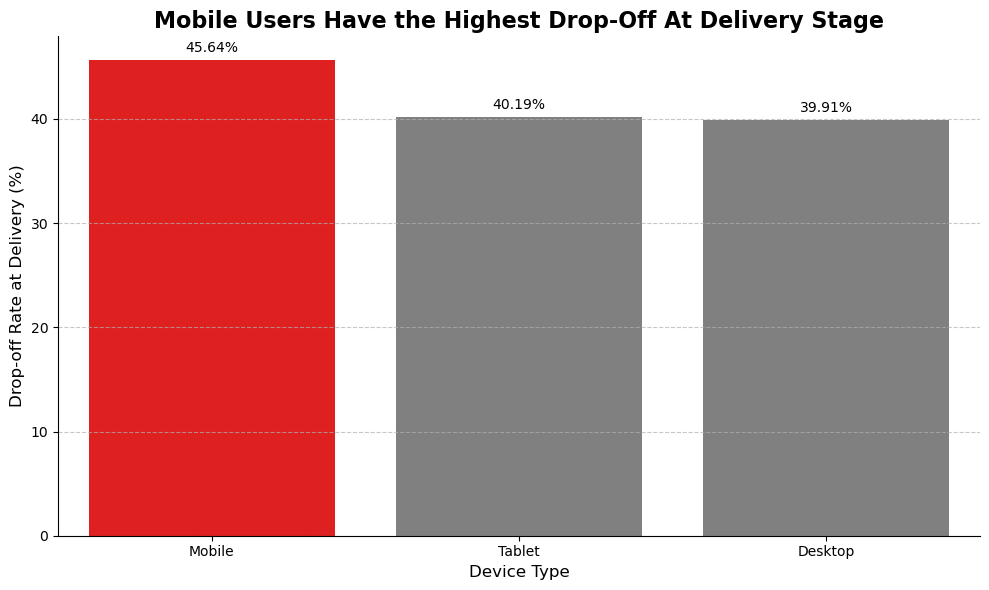

In [41]:
# 2.3 Device Segmentation
# Hypothesis: Device type affects user behavior and drop-off rates

import matplotlib.pyplot as plt
import seaborn as sns

# Filter sessions that reached 'Delivery' stage
delivery_stage_sessions = data[data['Checkout Stage 2 - Delivery'] == True]

# Group by device type
grouped_data = delivery_stage_sessions.groupby('Device Type')

# Calculate the number of users who dropped off and who proceeded
drop_offs = grouped_data.apply(lambda x: x[x['Checkout Stage 3 - Payment'] == False]['Session ID'].nunique())
proceeds = grouped_data.apply(lambda x: x[x['Checkout Stage 3 - Payment'] == True]['Session ID'].nunique())

# Calculate drop-off rates
drop_off_rates = (drop_offs / (drop_offs + proceeds)) * 100
drop_off_rates = drop_off_rates.reset_index()
drop_off_rates.columns = ['Device Type', 'Drop-off Rate at Delivery (%)']

# Identify the device type with the highest drop-off rate
worst_device_type = drop_off_rates.loc[drop_off_rates['Drop-off Rate at Delivery (%)'].idxmax(), 'Device Type']

# Sort the data for better visualization
drop_off_rates = drop_off_rates.sort_values(by='Drop-off Rate at Delivery (%)', ascending=False)

print(drop_off_rates)

# Plotting
plt.figure(figsize=(10, 6))

# Define colors, highlighting the worst device type
colors = ['red' if x == worst_device_type else 'grey' for x in drop_off_rates['Device Type']]

# Create bar plot
ax = sns.barplot(x='Device Type', y='Drop-off Rate at Delivery (%)', data=drop_off_rates, palette=colors)

# Annotate the bars with the drop-off rates
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 0.5, f"{y:.2f}%", ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot to fit Dyson branding
# Adjust the title based on the worst-performing device type
plt.title(f"{worst_device_type} Users Have the Highest Drop-Off At Delivery Stage", fontsize=16, fontweight='bold', color='#000000')
plt.xlabel('Device Type', fontsize=12, color='#000000')
plt.ylabel('Drop-off Rate at Delivery (%)', fontsize=12, color='#000000')
plt.xticks(fontsize=10, color='#000000')  # Labels are not rotated
plt.yticks(fontsize=10, color='#000000')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#FFFFFF')
plt.gcf().set_facecolor('#FFFFFF')
sns.despine()

# Save the figure as PNG before showing it
plt.tight_layout()
plt.savefig('drop_off_rates_by_device_type.png', dpi=300)

plt.show()


In [13]:
#PART 3: A/B Test Framework
# 3.1 Calculate sessions to delivery page for power analysis
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Filter sessions that reached the 'Delivery' page
delivery_page_data = data[data['Checkout Stage 2 - Delivery'] == True]

# Total unique sessions reaching the 'Delivery' page
delivery_page_sessions = delivery_page_data['Session ID'].nunique()

# Visits to 'Delivery' page per day
delivery_visits_per_day = delivery_page_data.groupby(delivery_page_data['Date'].dt.date)['Session ID'].nunique()
average_delivery_visits_per_day = delivery_visits_per_day.mean()

# Visits to 'Delivery' page per week
delivery_visits_per_week = delivery_page_data.groupby(delivery_page_data['Date'].dt.isocalendar().week)['Session ID'].nunique()
average_delivery_visits_per_week = delivery_visits_per_week.mean()

print(f"Total Sessions Reaching 'Delivery' Page: {delivery_page_sessions}")
print(f"Average Visits to 'Delivery' Page per Day: {average_delivery_visits_per_day:.2f}")
print(f"Average Visits to 'Delivery' Page per Week: {average_delivery_visits_per_week:.2f}\n")


Total Sessions Reaching 'Delivery' Page: 632
Average Visits to 'Delivery' Page per Day: 10.54
Average Visits to 'Delivery' Page per Week: 16.87



In [14]:
# 3.1bUse real traffic data
# according to similarweb tracking there are 1M monthly visits to dyson.co.uk
# keeping the rates constant we estimate delivery visits
average_delivery_visits_per_day = 616*1000000/1300
print(f"Average Visits to 'Delivery' Page per Day: {average_delivery_visits_per_day:.0f}")


Average Visits to 'Delivery' Page per Day: 473846


In [15]:
# 2.2 AOV
#Filter converted orders with 'Order Value' greater than zero
converted_orders = data[(data['Converted'] == True) & (data['Order Value'] > 0)]

if not converted_orders.empty:
    AOV = converted_orders['Order Value'].mean()
else:
    AOV = 0

print(f"Average Order Value (AOV): £{AOV:.2f}\n")


Average Order Value (AOV): £297.64



In [16]:
#3.3 Sample Size
from statsmodels.stats.power import NormalIndPower

# Baseline conversion rate (as a proportion)
baseline_rate = 0.2613

# Desired Minimum Detectable Effect (e.g., aiming for a 5% relative increase)
relative_increase = 0.05  # 5% increase
target_rate = baseline_rate * (1 + relative_increase)

# Effect size calculation using Cohen's h formula
effect_size = 2 * np.arcsin(np.sqrt(target_rate)) - 2 * np.arcsin(np.sqrt(baseline_rate))

# Significance level (alpha) and power
alpha = 0.05  # 95% confidence level
power = 0.8   # 80% power

# Sample size per group
analysis = NormalIndPower()
sample_size_per_group = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)
sample_size_per_group = int(np.ceil(sample_size_per_group))

print(f"Required Sample Size per Group: {sample_size_per_group}")
print(f"Total Sample Size Needed: {sample_size_per_group * 2}")

Required Sample Size per Group: 18032
Total Sample Size Needed: 36064


In [17]:
# 3.4 Estimated duration needed for test
average_daily_delivery_visits = average_delivery_visits_per_day
if average_daily_delivery_visits > 0:
    days_needed = np.ceil((sample_size_per_group * 2) / average_daily_delivery_visits)
else:
    days_needed = 0
print(f"Estimated Duration Needed for Test: {days_needed} days\n")

Estimated Duration Needed for Test: 1.0 days



In [18]:
# 3.5 Business Impact Estimation

# Estimated additional conversions
estimated_additional_conversions = 1000000 * baseline_rate * relative_increase

# Potential revenue increase
potential_revenue_increase = estimated_additional_conversions * AOV

print(f"Estimated Additional Conversions: {estimated_additional_conversions:.0f}")
print(f"Potential Revenue Increase: £{potential_revenue_increase:,.2f}")

Estimated Additional Conversions: 13065
Potential Revenue Increase: £3,888,652.08
